In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import h5py
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from ModuleLibrary.metrics import MCC, BA

2022-05-10 15:26:44.584200: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
# Gestion du padding
def padding_slidding(input, kernel):
    arr = np.append(np.zeros(((kernel // 2) + ((kernel % 2) - 1),input.shape[1])), input, axis=0) 
    arr = np.append(arr, np.zeros((kernel//2,input.shape[1])), axis=0)
    arr = sliding_window_view(arr, kernel, axis=0)
    output = arr.flatten(order='K').reshape((input.shape[0],kernel,input.shape[1]))
    return output

# Fenêtre glissante
def sliding_window_view(x, window_shape, axis=None, *, subok=False, writeable=False):
    '''
    Takes an numpy array and a window size and return a vectorized
    sliding window. 
    '''
    window_shape = (tuple(window_shape)
                    if np.iterable(window_shape)
                    else (window_shape,))
    # first convert input to array, possibly keeping subclass
    x = np.array(x, copy=False, subok=subok)

    window_shape_array = np.array(window_shape)
    if np.any(window_shape_array < 0):
        raise ValueError('`window_shape` cannot contain negative values')

    if axis is None:
        axis = tuple(range(x.ndim))
        if len(window_shape) != len(axis):
            raise ValueError(f'Since axis is `None`, must provide '
                             f'window_shape for all dimensions of `x`; '
                             f'got {len(window_shape)} window_shape elements '
                             f'and `x.ndim` is {x.ndim}.')
    else:
        axis = np.core.numeric.normalize_axis_tuple(axis, x.ndim, allow_duplicate=True)
        if len(window_shape) != len(axis):
            raise ValueError(f'Must provide matching length window_shape and '
                             f'axis; got {len(window_shape)} window_shape '
                             f'elements and {len(axis)} axes elements.')

    out_strides = x.strides + tuple(x.strides[ax] for ax in axis)

    # note: same axis can be windowed repeatedly
    x_shape_trimmed = list(x.shape)
    for ax, dim in zip(axis, window_shape):
        if x_shape_trimmed[ax] < dim:
            raise ValueError(
                'window shape cannot be larger than input array shape')
        x_shape_trimmed[ax] -= dim - 1
    out_shape = tuple(x_shape_trimmed) + window_shape
    return np.lib.stride_tricks.as_strided(x, strides=out_strides, shape=out_shape,
                      subok=subok, writeable=writeable)

In [75]:
class Layer():

    def __init__(self, name):
        self.name = name

    def compute_contrib(self):
        pass

    def set_output(self, model, data):
        self.output = np.squeeze(Model(inputs=model.inputs, outputs=model.get_layer(name=self.name).output).predict(data))

    def set_weights(self, model_w):
        self.weights = np.squeeze(np.array(model_w['model_weights'][self.name][self.name]['kernel:0']))

    def set_bias(self, model_w):
        self.bias = np.squeeze(np.array(model_w['model_weights'][self.name][self.name]['bias:0']))

class Conv(Layer):

    def __init__(self, name, model_w, kernel, padding, first):
        super().__init__(name)
        self.set_weights(model_w)
        self.set_bias(model_w)
        self.kernel = kernel
        self.padding = padding
        self.first = first

    def compute_contrib(self):
        super().compute_contrib()
        self.output_contrib[self.output <= 0] *= 1
        if self.padding == 'valid':
            input = sliding_window_view(self.input, self.kernel[0], axis=0)
            input = input.flatten(order='K').reshape((input.shape[0],input.shape[2],input.shape[1]))
        else:
            input = padding_slidding(self.input, self.kernel[0])
        if self.first:
            print(input.shape, self.weights.shape, self.output_contrib.shape)
            self.input_contrib = np.einsum('ijk,kl,il->ijk', input, self.weights, self.output_contrib)
            #self.input_contrib = np.einsum('ijk,jkl,il->ijk', input, self.weights, self.output_contrib)
        else:       
            self.input_contrib = np.einsum('ijk,jkl,il->ik', input, self.weights, self.output_contrib)

class Dense(Layer):

    def __init__(self, name, model_w, units):
        super().__init__(name)
        self.set_weights(model_w)
        self.set_bias(model_w)
        self.units = units

    def compute_contrib(self): 
        super().compute_contrib()
        if self.units > 1:
            self.output_contrib[self.output <= 0] *= 1
            self.input_contrib = np.einsum('i,ij,j->i', self.input, self.weights, self.output_contrib)
        else:
            self.input_contrib = self.input * self.weights
            

class MaxPooling(Layer):

    def __init__(self, name, pool_size):
        super().__init__(name)
        self.pool_size = pool_size

    def compute_contrib(self): ### Can be optimized
        super().compute_contrib()
        self.input_contrib = np.zeros((self.input.shape[0], self.input.shape[1])) 
        print(self.input_contrib.shape)
        if self.input_contrib.shape[0] % 2 == 0:
            size = self.input_contrib.shape[0]
        else:
            size = self.input_contrib.shape[0] - 1
        for i in range(0,size,2):
            for j in range(self.input_contrib.shape[1]):
                if self.input[i][j] > self.input[i+1][j]:
                    self.input_contrib[i][j] = self.output_contrib[int(i/2)][j]
                else:
                    self.input_contrib[i+1][j] = self.output_contrib[int(i/2)][j]

class Flatten(Layer):

    def __init__(self, name):
        super().__init__(name)

    def compute_contrib(self):
        super().compute_contrib()
        self.input_contrib = self.output_contrib.reshape((self.input.shape[0], self.input.shape[1]))

class Input(Layer):

    def __init__(self, name):
        super().__init__(name)

    def set_output(self, model, data):
        self.output = np.squeeze(data)

    def compute_contrib(self): 
        super().compute_contrib()
        self.input_contrib = np.zeros((self.output.shape))
        for i in range(self.output_contrib.shape[0]):
            self.input_contrib[i:i+6] = np.add(self.input_contrib[i:i+6], self.output_contrib[i])

        maxvalue = max(float(np.max(self.input_contrib)),float(-np.min(self.input_contrib)))
        for i in range(len(self.input_contrib)):
            for j in range(4):
                self.input_contrib[i][j] = self.input_contrib[i][j] / maxvalue

        self.input_contrib = np.transpose(self.input_contrib)


class Features_exploration():

    def __init__(self, model_path):
        self.model = load_model(model_path, custom_objects={'MCC': MCC, 'BA' : BA})
        self.model_w = h5py.File(model_path,'r')
        self.layers = []
        self.build_model()
        
    def build_model(self):
        first_conv = True
        for layer in self.model.get_config()['layers']:

            if layer['class_name'].startswith('Conv'):
                name = layer['config']['name']
                kernel = layer['config']['kernel_size']
                padding = layer['config']['padding']
                self.layers.append(Conv(name, self.model_w, kernel, padding, first_conv))
                first_conv = False

            elif layer['class_name'].startswith('MaxPooling'):
                name = layer['config']['name']
                pool_size = layer['config']['pool_size']
                self.layers.append(MaxPooling(name, pool_size))

            elif layer['class_name'].startswith('Dense'):
                name = layer['config']['name']
                units = layer['config']['units']
                self.layers.append(Dense(name, self.model_w, units))

            elif layer['class_name'].startswith('Flatten'):
                name = layer['config']['name']
                self.layers.append(Flatten(name))

            elif layer['class_name'].startswith('Input'):
                name = layer['config']['name']
                self.layers.append(Input(name))
            else:
                continue

    def explore(self, data):

        data = data.reshape(1,data.shape[0], data.shape[1],1)

        for i, layer in enumerate(self.layers):
            layer.set_output(self.model, data)
            if i > 0:
                layer.input = self.layers[i-1].output
                
        self.layers.reverse()

        for i, layer in enumerate(self.layers):
            print(i, len(self.layers))
            layer.compute_contrib()
            if i != len(self.layers) - 1:
                self.layers[i+1].output_contrib = layer.input_contrib

        self.plot()
       

    def plot(self):

        cim = plt.imread("ModuleLibrary/colorbar.png")
        cim = cim[cim.shape[0]//2, 50:390, :]
        cmap = mcolors.ListedColormap(cim)
        plt.figure(figsize=(34,1), dpi= 200)
        plt.imshow(self.layers[-1].input_contrib, cmap=cmap, aspect='auto', vmin=-1, vmax=1)
        plt.xticks(np.arange(0, 10001,10))
        plt.yticks([0,1,2,3], ['a','t','g','c'])
        plt.colorbar()
        plt.show()

## Exemple d'utilisation

In [76]:
#model_path = 'Results/newHS37_exon_start/best_metrics_model.hdf5'
model_path = 'Results/HS37_coverage_BN_3/best_metrics_model.hdf5'

# Chargement du modèle et des poids
exemple = Features_exploration(model_path)

# Chargement de l'input (en one_hot)
data = np.load(f'Data/DNA/HS37/one_hot/chr1.npy').astype('int8')


In [61]:
print(exemple.layers[-1].input_contrib)

[[ 0.00000000e+00 -5.55522109e-04  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00 -4.07244337e-02]
 [-6.96515640e-05  0.00000000e+00  2.40146920e-04 ...  0.00000000e+00
  -1.93063435e-02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.34881442e-03
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


0 19
1 19
2 19
3 19
4 19
5 19
(312, 128)
6 19
7 19
(625, 128)
8 19
9 19
(1250, 64)
10 19
11 19
(2500, 64)
12 19
13 19
(5000, 32)
14 19
15 19
(10001, 32)
16 19
17 19
(10001, 1, 4) (4, 16) (10001, 16)
18 19


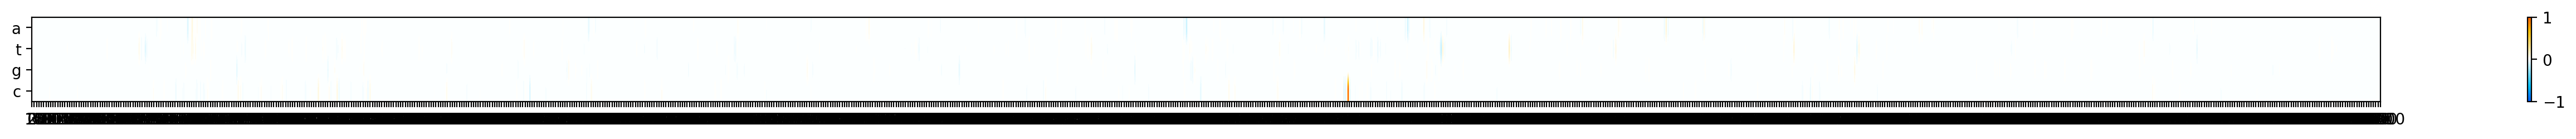

In [77]:
index = 150000
data2 = data[index:(index+10001)] 
exemple.explore(data2)